# Bag of Words Meets Bags of Popcorn

In [1]:
# Use the Azure Machine Learning data source package
from azureml.dataprep import datasource

In [24]:
# classifier models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# modules to handle data
import os
import pandas as pd
import numpy as np
from IPython.display import display

from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [9]:
# load data 
train_labeled = datasource.load_datasource('labeledTrainData.dsource')
train_unlabeled = datasource.load_datasource('unlabeledTrainData.dsource')
test = datasource.load_datasource('testData.dsource')

## Bag of Words Approach

### Data Cleaning and Text Preprocessing

In [123]:
print('Dimension of Labeled Training Data: {}.'.format(train_labeled.shape))
print('There are {0} samples and {1} variables in the training data.'.format(train_labeled.shape[0], train_labeled.shape[1]))

Dimension of Labeled Training Data: (10000, 3).
There are 10000 samples and 3 variables in the training data.


In [124]:
display(train_labeled.head())

,id,sentiment,review
0,5814_8,1.0,With all this stuff going down at the moment w...
1,2381_9,1.0,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0.0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0.0,It must be assumed that those who praised this...
4,9495_8,1.0,Superbly trashy and wondrously unpretentious 8...


In [125]:
#taking a closer look
print(train_labeled.review[0])

With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally star

##### Removing HTML Markup with The BeautifulSoup Package

In [126]:
train_labeled['review_bs'] = train_labeled['review'].apply(lambda x: BeautifulSoup(x, 'html.parser'))

In [127]:
train_labeled.review_bs[0].get_text()

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.The actual feature film bit when it finally starts is only on for 20 mi

##### Dealing with Punctuation, Numbers and Stopwords

In [130]:
#Using re package to remove digits and punctuations. 
#To build a simplified Bag-of-words model, I removed both digits and punctuations
train_labeled['review_letters_only'] = train_labeled['review_bs'].apply(lambda x: re.sub(r'[^a-zA-Z]', ' ', x.get_text()))

In [131]:
train_labeled['review_letters_only'][0]

'With all this stuff going down at the moment with MJ i ve started listening to his music  watching the odd documentary here and there  watched The Wiz and watched Moonwalker again  Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent  Moonwalker is part biography  part feature film which i remember going to see at the cinema when it was originally released  Some of it has subtle messages about MJ s feeling towards the press and also the obvious message of drugs are bad m kay Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring  Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him The actual feature film bit when it finally starts is only on for    mi

In [132]:
#Converting words into lower case and tonkenizing, i.e. split the text into individual words.
train_labeled['review_words'] = train_labeled['review_letters_only'].apply(lambda x: x.lower().split())

In [133]:
train_labeled['review_words'][0]

['with',
 'all',
 'this',
 'stuff',
 'going',
 'down',
 'at',
 'the',
 'moment',
 'with',
 'mj',
 'i',
 've',
 'started',
 'listening',
 'to',
 'his',
 'music',
 'watching',
 'the',
 'odd',
 'documentary',
 'here',
 'and',
 'there',
 'watched',
 'the',
 'wiz',
 'and',
 'watched',
 'moonwalker',
 'again',
 'maybe',
 'i',
 'just',
 'want',
 'to',
 'get',
 'a',
 'certain',
 'insight',
 'into',
 'this',
 'guy',
 'who',
 'i',
 'thought',
 'was',
 'really',
 'cool',
 'in',
 'the',
 'eighties',
 'just',
 'to',
 'maybe',
 'make',
 'up',
 'my',
 'mind',
 'whether',
 'he',
 'is',
 'guilty',
 'or',
 'innocent',
 'moonwalker',
 'is',
 'part',
 'biography',
 'part',
 'feature',
 'film',
 'which',
 'i',
 'remember',
 'going',
 'to',
 'see',
 'at',
 'the',
 'cinema',
 'when',
 'it',
 'was',
 'originally',
 'released',
 'some',
 'of',
 'it',
 'has',
 'subtle',
 'messages',
 'about',
 'mj',
 's',
 'feeling',
 'towards',
 'the',
 'press',
 'and',
 'also',
 'the',
 'obvious',
 'message',
 'of',
 'drugs',

In [134]:
#Removing stop words with ntlk
set_of_stopwords = set(stopwords.words("english"))
train_labeled['review_meaningful_words'] = train_labeled['review_words'].apply(lambda x: [w for w in x if not w in set_of_stopwords])

In [135]:
num_removed = len(train_labeled['review_words'][0]) - len(train_labeled['review_meaningful_words'][0])
print('For the first review entry, the number of stop words removed is {0}.'.format(num_removed))

For the first review entry, the number of stop words removed is 218.


Note: We can also stem the words with PorterStemmer() and Lemmatizer() to consider only word stems. But for this training data, better results was produced without stemming.

In [136]:
# porter_stemmer = PorterStemmer()
# wordnet_lemmatizer = WordNetLemmatizer()

# train['review_stemmed'] = train['review_meaningful_words'].apply(
#     lambda x: [porter_stemmer.stem(w) for w in x])
# train['review_stemmed'] = train['review_cleaned'].apply(
#     lambda x: [wordnet_lemmatizer.lemmatize(w) for w in x])

In [137]:
#joining the list of words into a single string.
train_labeled['review_cleaned'] = train_labeled['review_meaningful_words'].apply(lambda x: ' '.join(x))

In [145]:
#Modularizing the data cleaning process
def clean_reviews(reviews, remove_stopwords=False, stem=False):
    # 1. Remove HTML
    reviews_text = list(map(lambda x: BeautifulSoup(x, 'html.parser').get_text(), reviews))
    # 2. Remove non-letters
    reviews_text = list(map(lambda x: re.sub("[^a-zA-Z]"," ", x), reviews_text))
    # 3. Convert words to lower case and split them
    words = list(map(lambda x: x.lower().split(), reviews_text))
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        set_of_stopwords = set(stopwords.words("english"))
        meaningful_words = list(map(lambda x: [w for w in x if not w in set_of_stopwords], words))
    # 5. Optionally stem the words
    if stem:
        porter_stemmer = PorterStemmer()
        wordnet_lemmatizer = WordNetLemmatizer()
        stemmed_words = list(map(lambda x: [porter_stemmer.stem(w) for w in x], meaningful_words))
        stemmed_words = list(map(lambda x:[wordnet_lemmatizer.lemmatize(w) for w in x], stemmed_words))
    # 6. Join the words to a single string
        clean_review = map(lambda x: ' '.join(x), stemmed_words)
    else:
        clean_review = list(map(lambda x: ' '.join(x), meaningful_words))
    return clean_review

#### Word Cloud

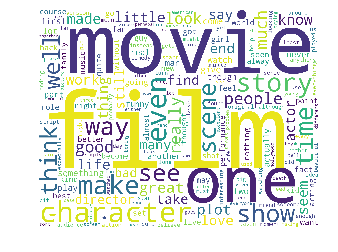

In [73]:
from scipy.misc.pilutil import imread #pip install Pillow==2.6.0
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
#ms_mask = imread(datasource.load_datasource('windows_logo.png'), flatten=True)
wordcloud = WordCloud( 
                      stopwords=STOPWORDS,
                      background_color='white',
                      width=1800,
                      height=1400
                      #,mask=ms_mask
                     ).generate(' '.join(train_labeled['review_cleaned']))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [31]:
#train_labeled.drop(['review', 'review_bs', 'review_letters_only', 'review_words', 'review_meaningful_words'], 
           #axis=1, inplace=True)
display(train_labeled.head())

,id,sentiment,review_cleaned
0,5814_8,1.0,stuff going moment mj started listening music ...
1,2381_9,1.0,classic war worlds timothy hines entertaining ...
2,7759_3,0.0,film starts manager nicholas bell giving welco...
3,3630_4,0.0,must assumed praised film greatest filmed oper...
4,9495_8,1.0,superbly trashy wondrously unpretentious explo...


In [138]:
print(train_labeled['review_cleaned'][0])

stuff going moment mj started listening music watching odd documentary watched wiz watched moonwalker maybe want get certain insight guy thought really cool eighties maybe make mind whether guilty innocent moonwalker part biography part feature film remember going see cinema originally released subtle messages mj feeling towards press also obvious message drugs bad kay visually impressive course michael jackson unless remotely like mj anyway going hate find boring may call mj egotist consenting making movie mj fans would say made fans true really nice actual feature film bit finally starts minutes excluding smooth criminal sequence joe pesci convincing psychopathic powerful drug lord wants mj dead bad beyond mj overheard plans nah joe pesci character ranted wanted people know supplying drugs etc dunno maybe hates mj music lots cool things like mj turning car robot whole speed demon sequence also director must patience saint came filming kiddy bad sequence usually directors hate working

### Supervised Learning - CountVectorizer

In [33]:
#Initializing the CountVectorizer object. 
#CountVectorizer converts a collection of text documents to a matrix of token counts.
vectorizer = CountVectorizer(analyzer="word", preprocessor=None, tokenizer=None, stop_words=None, max_features=5000)

In [34]:
train_data_features = vectorizer.fit_transform(list(train_labeled['review_cleaned'].values))
# Numpy arrays are easy to work with, so convert the result to an array
train_data_features = train_data_features.toarray()

In [37]:
#The resulting train_data_features is an array which contains the occurrence of bag of words in our training data. 
train_data_features[0]

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [38]:
print('The dimension of train_data_features is {}.'.format(train_data_features.shape))

The dimension of train_data_features is (10000, 5000).


In [39]:
#With get_feature_names() method, we can take a look at the bag of words which is a list of 5000 words.
vocab = vectorizer.get_feature_names()
print(vocab)

['abandoned', 'abc', 'abilities', 'ability', 'able', 'abraham', 'absence', 'absolute', 'absolutely', 'absurd', 'abuse', 'abusive', 'academy', 'accent', 'accents', 'accept', 'acceptable', 'accepted', 'access', 'accident', 'accidentally', 'accomplished', 'according', 'account', 'accurate', 'accused', 'ace', 'achieve', 'achieved', 'achievement', 'across', 'act', 'acted', 'acting', 'action', 'actions', 'active', 'actor', 'actors', 'actress', 'actresses', 'acts', 'actual', 'actually', 'ad', 'adam', 'adams', 'adaptation', 'adapted', 'add', 'added', 'adding', 'addition', 'adds', 'adequate', 'admire', 'admit', 'admittedly', 'adolescent', 'adorable', 'adult', 'adults', 'advance', 'advanced', 'advantage', 'adventure', 'adventures', 'advertising', 'advice', 'advise', 'affair', 'affairs', 'affect', 'affected', 'afford', 'aforementioned', 'afraid', 'africa', 'african', 'afternoon', 'afterwards', 'age', 'aged', 'agency', 'agenda', 'agent', 'agents', 'ages', 'aging', 'ago', 'agree', 'agreed', 'agrees

In [40]:
import numpy as np
#frequency of each word is found using np.sum()
dist = np.sum(train_data_features,axis=0)
ct = 0
for tag,count in zip(vocab,dist):
    print(tag,":",count,end=" ")

abandoned : 88 abc : 61 abilities : 46 ability : 185 able : 557 abraham : 36 absence : 43 absolute : 122 absolutely : 584 absurd : 109 abuse : 84 abusive : 38 academy : 107 accent : 198 accents : 84 accept : 141 acceptable : 58 accepted : 56 access : 39 accident : 127 accidentally : 76 accomplished : 51 according : 131 account : 75 accurate : 129 accused : 53 ace : 32 achieve : 68 achieved : 60 achievement : 48 across : 424 act : 530 acted : 267 acting : 2554 action : 1395 actions : 129 active : 34 actor : 948 actors : 1842 actress : 513 actresses : 148 acts : 166 actual : 303 actually : 1669 ad : 58 adam : 113 adams : 37 adaptation : 175 adapted : 63 add : 313 added : 180 adding : 72 addition : 130 adds : 130 adequate : 47 admire : 53 admit : 232 admittedly : 44 adolescent : 38 adorable : 39 adult : 207 adults : 128 advance : 38 advanced : 46 advantage : 60 adventure : 213 adventures : 81 advertising : 40 advice : 96 advise : 39 affair : 128 affairs : 35 affect : 36 affected : 56 affo

: 37 chaplin : 53 chapter : 43 character : 2810 characterization : 50 characters : 2886 charge : 65 charisma : 54 charismatic : 63 charles : 165 charlie : 206 charlotte : 50 charm : 165 charming : 180 chase : 181 chased : 37 chases : 56 chasing : 63 chavez : 42 che : 107 cheap : 373 cheated : 42 cheating : 34 check : 343 checked : 32 checking : 50 cheek : 40 cheese : 63 cheesy : 251 chemistry : 186 cher : 38 chess : 48 chest : 39 chick : 80 chief : 103 child : 530 childhood : 141 childish : 41 children : 598 chilling : 78 chills : 35 china : 78 chinese : 138 choice : 212 choices : 68 choose : 86 chooses : 35 choppy : 37 choreographed : 41 choreography : 55 chorus : 35 chose : 72 chosen : 88 chris : 185 christ : 77 christian : 161 christians : 45 christmas : 227 christopher : 152 christy : 60 chuck : 35 church : 152 cia : 40 cinderella : 62 cinema : 584 cinematic : 154 cinematographer : 47 cinematography : 431 circle : 35 circumstances : 83 cities : 37 citizen : 41 citizens : 33 city : 

 eating : 103 eccentric : 44 ed : 133 eddie : 118 edgar : 40 edge : 192 edgy : 44 edie : 58 edit : 33 edited : 110 editing : 298 edition : 42 editor : 44 educated : 33 education : 38 edward : 85 eerie : 62 effect : 247 effective : 224 effectively : 71 effects : 852 effort : 294 efforts : 113 ego : 50 eight : 82 eighties : 41 either : 744 el : 34 elaborate : 40 elderly : 49 elegant : 34 element : 173 elements : 294 elephant : 36 elizabeth : 76 ellen : 44 else : 850 elsewhere : 58 elvira : 86 elvis : 85 em : 61 embarrassed : 73 embarrassing : 93 embarrassment : 46 emily : 53 emma : 62 emotion : 155 emotional : 271 emotionally : 88 emotions : 159 emphasis : 38 empire : 40 empty : 122 en : 38 encounter : 78 encounters : 60 encourage : 32 end : 2219 endearing : 54 ended : 224 ending : 1003 endings : 49 endless : 95 ends : 409 enemies : 39 enemy : 94 energy : 146 engage : 38 engaged : 42 engaging : 124 england : 129 english : 386 enjoy : 718 enjoyable : 325 enjoyed : 512 enjoying : 84 enjoym

: 59 heat : 50 heaven : 120 heavily : 70 heavy : 181 heck : 89 heels : 34 heights : 35 held : 170 helen : 60 helicopter : 49 hell : 384 hello : 34 help : 796 helped : 134 helping : 64 helps : 138 hence : 59 henry : 135 hepburn : 41 hero : 409 heroes : 137 heroic : 56 heroine : 116 heston : 53 hey : 144 hidden : 154 hide : 78 hideous : 43 hiding : 55 high : 823 higher : 112 highest : 43 highlight : 73 highlights : 53 highly : 459 hilarious : 391 hill : 95 hills : 77 hint : 62 hints : 41 hip : 83 hippie : 37 hire : 55 hired : 69 historical : 165 historically : 39 history : 536 hit : 436 hitchcock : 103 hitler : 141 hits : 122 hitting : 59 hk : 37 ho : 72 hoffman : 86 hold : 213 holding : 88 holds : 131 hole : 69 holes : 143 holiday : 55 hollow : 52 holly : 41 hollywood : 833 holmes : 32 holy : 57 homage : 61 home : 808 homeless : 57 homer : 63 honest : 185 honestly : 180 honesty : 39 hong : 81 honor : 61 hood : 75 hook : 40 hooked : 73 hop : 52 hope : 596 hoped : 59 hopefully : 81 hopele

 manager : 71 manages : 249 mandy : 32 manhattan : 49 maniac : 38 manipulative : 35 mankind : 36 mann : 57 manner : 174 mannerisms : 32 mansion : 80 many : 2741 map : 33 marc : 36 march : 44 margaret : 42 maria : 75 marie : 93 mario : 42 marion : 38 mark : 252 market : 91 marks : 41 marriage : 138 married : 246 marries : 35 marry : 86 mars : 36 marshall : 39 martial : 138 martin : 124 marty : 37 marvel : 33 marvelous : 58 mary : 233 mask : 102 masks : 40 mass : 55 massacre : 58 massive : 78 master : 175 masterful : 38 masterpiece : 253 masterpieces : 36 masters : 48 match : 328 matches : 49 mate : 45 material : 308 mathieu : 53 matrix : 73 matt : 103 matter : 443 matters : 82 matthau : 54 matthew : 43 mature : 61 max : 79 may : 1353 maybe : 903 mean : 683 meaning : 194 meaningful : 64 meaningless : 49 means : 297 meant : 253 meanwhile : 95 measure : 33 meat : 46 mechanical : 39 media : 140 medical : 58 mediocre : 146 medium : 48 meet : 272 meeting : 91 meets : 285 mel : 37 melodrama : 

: 99 president : 95 press : 55 presumably : 57 pretend : 55 pretending : 42 pretentious : 113 pretty : 1495 prevent : 48 preview : 42 previous : 279 previously : 75 prey : 36 price : 104 priceless : 34 pride : 66 priest : 72 primarily : 37 primary : 46 prime : 76 prince : 121 princess : 81 print : 77 prior : 73 prison : 204 prisoner : 40 prisoners : 34 private : 117 prize : 40 pro : 62 probably : 1159 problem : 557 problems : 350 proceedings : 41 process : 122 produce : 95 produced : 233 producer : 168 producers : 194 producing : 45 product : 82 production : 741 productions : 64 profanity : 32 profession : 32 professional : 127 professor : 80 profound : 65 program : 88 progress : 38 progresses : 38 project : 208 projects : 54 prom : 65 promise : 87 promised : 46 promising : 84 proof : 59 propaganda : 89 proper : 77 properly : 74 property : 37 props : 38 prostitute : 46 protagonist : 98 protagonists : 59 protect : 69 proud : 74 prove : 117 proved : 109 proves : 158 provide : 132 provide

 slick : 37 slight : 52 slightest : 49 slightly : 228 sloppy : 42 slow : 442 slowly : 154 slugs : 33 small : 699 smaller : 40 smart : 183 smile : 106 smith : 195 smoke : 44 smoking : 52 smooth : 47 snake : 44 snakes : 35 sneak : 33 snl : 37 snow : 68 soap : 104 soccer : 50 social : 233 society : 289 soft : 119 sold : 65 soldier : 128 soldiers : 158 sole : 45 solely : 44 solid : 220 solo : 37 solution : 34 solve : 56 somebody : 130 somehow : 300 someone : 921 something : 2053 sometimes : 499 somewhat : 393 somewhere : 221 son : 560 song : 416 songs : 371 sons : 64 soon : 470 sophisticated : 66 sorry : 284 sort : 574 sorts : 85 soul : 166 souls : 52 sound : 482 sounded : 63 sounding : 46 sounds : 283 soundtrack : 315 source : 77 south : 190 southern : 71 soviet : 38 space : 299 spacey : 32 spain : 38 spanish : 116 spare : 51 speak : 204 speaking : 156 speaks : 77 special : 819 species : 45 specific : 57 specifically : 42 spectacular : 94 speech : 75 speed : 111 spell : 51 spend : 217 spe

: 42 uses : 225 using : 318 ustinov : 35 usual : 394 usually : 388 utter : 100 utterly : 189 uwe : 43 vacation : 63 vague : 54 vaguely : 39 valentine : 35 valley : 36 valuable : 38 value : 214 values : 197 vampire : 172 vampires : 121 van : 184 vanessa : 43 vargas : 33 variety : 66 various : 248 vast : 34 vegas : 40 vehicle : 107 vengeance : 35 verhoeven : 46 version : 866 versions : 115 versus : 42 veteran : 78 vhs : 105 via : 74 vice : 41 vicious : 50 victim : 156 victims : 164 victor : 110 victoria : 83 victory : 38 video : 701 videos : 72 vietnam : 61 view : 395 viewed : 82 viewer : 508 viewers : 300 viewing : 301 viewings : 35 views : 80 village : 119 villain : 231 villains : 99 vincent : 51 violence : 431 violent : 207 virgin : 53 virginia : 44 virtually : 87 virus : 52 vision : 122 visions : 33 visit : 92 visited : 33 visual : 211 visually : 93 visuals : 108 vivid : 50 voice : 460 voiced : 33 voices : 76 voight : 58 von : 59 vote : 92 vs : 121 vulnerable : 35 wacky : 38 wagner :

In [41]:
startswith = []
for val in vocab:
    if(val[0] not in startswith):
        startswith.append(val[0])
print(startswith)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'y', 'z']


In [42]:
#counting the total numbers of words starting
counts = np.zeros((len(startswith)),dtype=np.int)
for val in vocab:
    index = startswith.index(val[0])
    counts[index] += 1
print(counts)

[310 277 475 293 219 255 151 195 158  72  63 206 273 113  86 331  15 285
 590 268  78  69 196  16   6]


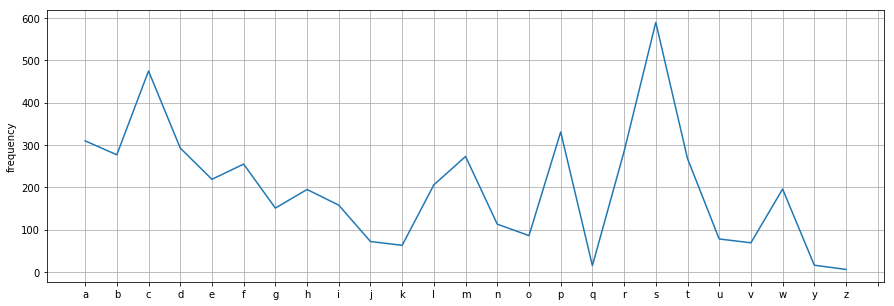

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(1,figsize=(15,5))
plt.plot(counts)
nums = [i for i in range(26)]
plt.xticks(nums,startswith)
plt.grid()
plt.ylabel("frequency")
plt.show()

##### Random Forest - Take 1

In [76]:
# Initialize a Random Forest classifier with 100 trees
rf_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=0) 

# Use cross validation to evaluate the performance of Random Forest
rf_clf_error = 1 - cross_val_score(rf_clf, train_data_features, train_labeled['sentiment'], 
                                   cv=5, scoring='accuracy', n_jobs=-1).mean()

print('Random Forest training error: {:.4}'.format(rf_clf_error))

Random Forest training error: 0.1605


In [ ]:
# Fit the forest to the training set, using the bag of words as features and the sentiment labels as labels
# This may take a few minutes to run
rf_clf.fit(train_data_features, train['sentiment'])

# Use the random forest to make sentiment label predictions
result = rf_clf.predict(test_data_features)

# Copy the results to a pandas dataframe with an "id" column an a "sentiment" column
output = pd.DataFrame(data={"id":test["id"], "sentiment":result})

# Use pandas to write the comma-separated output file
output.to_csv("submissions/Bag_of_Words_rf_clf_results.csv", index=False, quoting=3)   
print("Wrote results to submissions/Bag_of_Words_rf_clf_results.csv")

### Supervised Learning - Word2Vec

In [92]:
# Set values for various parameters
num_features = 300    # Word vector dimensionality
min_word_count = 40   # Minimum word count
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

In [140]:
# Initialize and train the model
from gensim.models import word2vec

model = word2vec.Word2Vec(list(train_labeled['review_meaningful_words'].values), workers=num_workers,
            size=num_features, min_count = min_word_count,
            window = context, sample = downsampling)

In [141]:
model.most_similar("movie")

.jupyter/start_kernel_on_target.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  import argparse


[('expecting', 0.7495313882827759),
 ('admit', 0.7372495532035828),
 ('honestly', 0.7170853614807129),
 ('surprised', 0.7041427493095398),
 ('reviews', 0.6979706883430481),
 ('personally', 0.6907049417495728),
 ('disappointed', 0.6850419044494629),
 ('damn', 0.68328857421875),
 ('sure', 0.6806221008300781),
 ('hated', 0.6780094504356384)]

In [142]:
model.most_similar("loved")

.jupyter/start_kernel_on_target.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  import argparse


[('enjoyed', 0.8502101898193359),
 ('seeing', 0.8005592823028564),
 ('remember', 0.7997214794158936),
 ('watched', 0.7988767623901367),
 ('liked', 0.7941312193870544),
 ('favorite', 0.7516475915908813),
 ('saw', 0.7261008024215698),
 ('grew', 0.7184513807296753),
 ('twice', 0.718413233757019),
 ('watching', 0.7153857350349426)]

In [143]:
model.most_similar("hated")

.jupyter/start_kernel_on_target.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  import argparse


[('wow', 0.9338857531547546),
 ('kinda', 0.9061203002929688),
 ('embarrassed', 0.9055600762367249),
 ('anyway', 0.9032393097877502),
 ('laughed', 0.8999533653259277),
 ('sucks', 0.8973013162612915),
 ('admit', 0.8945050835609436),
 ('damn', 0.8815147876739502),
 ('gotta', 0.8782488107681274),
 ('honestly', 0.8759980201721191)]

### From Words To Paragraphs, Attempt 1: Vector Averaging

In [176]:
def makeFeatureVec(words, model, num_features):
    # Function to average all of the word vectors in a given paragraph
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0
    # Index2word is a list that contains the names of the words in
    # the model's vocabulary. Convert it to a set, for speed
    index2word_set = set(model.wv.index2word)
    # Loop over each word in the review and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in words:
        if word in index2word_set:
            nwords = nwords + 1
            featureVec = np.add(featureVec,model[word])
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords)
    return featureVec

def getAvgFeatureVecs(reviews, model, num_features):
    # Given a set of reviews (each one a list of words), calculate
    # the average feature vector for each one and return a 2D numpy array
    # Initialize a counter
    counter = 0
    # Preallocate a 2D numpy array, for speed
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    # Loop through the reviews
    for review in reviews:
        # Print a status message every 1000th review
        if counter%1000 == 0:
            print("Review %d of %d" % (counter, len(reviews)))
        # Call the function (defined above) that makes average feature vectors
        reviewFeatureVecs[counter] = makeFeatureVec(review, model, num_features)
        # Increment the counter
        counter = counter + 1
    return reviewFeatureVecs

In [177]:
clean_train_reviews = []
for c, review in enumerate(train_labeled["review"]):
    if c%1000. == 0.:
        print("Training set {} of {}".format(c, train_labeled.shape[0]))
    clean_train_reviews.append( clean_reviews( review, remove_stopwords=True ))
trainDataVecs = getAvgFeatureVecs( clean_train_reviews, model, num_features )

Training set 0 of 10000
Training set 1000 of 10000
Training set 2000 of 10000
Training set 3000 of 10000
Training set 4000 of 10000
Training set 5000 of 10000
Training set 6000 of 10000
Training set 7000 of 10000
Training set 8000 of 10000
Training set 9000 of 10000
Review 0 of 10000


.jupyter/start_kernel_on_target.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  with tempfile.TemporaryDirectory() as temp_dir:


Review 1000 of 10000
Review 2000 of 10000
Review 3000 of 10000
Review 4000 of 10000
Review 5000 of 10000
Review 6000 of 10000
Review 7000 of 10000
Review 8000 of 10000
Review 9000 of 10000


In [160]:
trainDataVecs

array([[ 0.03979146, -0.30883387, -0.3596183 , ...,  0.15690756,
         0.3344519 , -0.03772178],
       [ 0.04539384, -0.3148259 , -0.3585461 , ...,  0.15828629,
         0.327297  , -0.04152749],
       [ 0.0508813 , -0.3146527 , -0.34990543, ...,  0.15897246,
         0.32214582, -0.04974935],
       ...,
       [ 0.04508008, -0.31390572, -0.35303175, ...,  0.15718357,
         0.323722  , -0.04585609],
       [ 0.05391357, -0.31370208, -0.35484162, ...,  0.15872495,
         0.33121306, -0.04031219],
       [ 0.04202148, -0.30630568, -0.35421923, ...,  0.15834962,
         0.33498278, -0.04104795]], dtype=float32)

##### Random Forest - Take 2

In [173]:
# Fit a random forest to the training data, using 100 trees
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier( n_estimators = 100 )

print("Fitting a random forest to labeled training data...")
forest = forest.fit( trainDataVecs, train_labeled["sentiment"] )

rf_clf_error = 1 - cross_val_score(forest, train_data_features, train_labeled['sentiment'], 
                                   cv=5, scoring='accuracy', n_jobs=-1).mean()

print('Random Forest training error: {:.4}'.format(rf_clf_error))

Fitting a random forest to labeled training data...
Random Forest training error: 0.1631


In [ ]:
# Test & extract results
result = forest.predict( testDataVecs )

# Write the test results
output = pd.DataFrame( data={"id":test["id"], "sentiment":result} )
output.to_csv( "Word2Vec_AverageVectors.csv", index=False, quoting=3 )

### From Words to Paragraphs, Attempt 2: Clustering

In [163]:
from sklearn.cluster import KMeans
import time

start = time.time()

# Set "k" (num_clusters) to be 1/5th of the vocabulary size, or an
# average of 5 words per cluster
word_vectors = model.wv.syn0
num_clusters = int(word_vectors.shape[0] / 5)

print("the number of clusters: {}".format(num_clusters))

# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans( n_clusters = num_clusters )
idx = kmeans_clustering.fit_predict( word_vectors )

# Get the end time and print how long the process took
end = time.time()
elapsed = end - start
print("Time taken for K Means clustering: ", elapsed, "seconds.")

.jupyter/start_kernel_on_target.py:8: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  parser.add_argument('-f', type=str)


the number of clusters: 848
Time taken for K Means clustering:  26.693811178207397 seconds.


In [165]:
# Create a Word / Index dictionary, mapping each vocabulary word to
# a cluster number                                                                                            
word_centroid_map = dict(zip( model.wv.index2word, idx ))

In [166]:
word_centroid_map

{'ago': 38,
 'nearby': 816,
 'leads': 312,
 'sea': 466,
 'portrait': 331,
 'dust': 40,
 'outcome': 235,
 'enjoyed': 710,
 'warn': 122,
 'floating': 648,
 'samurai': 833,
 'visual': 655,
 'essence': 235,
 'entirely': 607,
 'jungle': 833,
 'multiple': 235,
 'awe': 388,
 'indeed': 595,
 'hotel': 780,
 'bound': 833,
 'smoking': 795,
 'flashback': 570,
 'cases': 158,
 'happens': 70,
 'loose': 617,
 'makeup': 534,
 'hell': 198,
 'stop': 793,
 'mountains': 13,
 'vivid': 14,
 'exact': 40,
 'straight': 453,
 'madness': 637,
 'post': 544,
 'married': 768,
 'greatest': 491,
 'ruined': 20,
 'wasting': 322,
 'macy': 753,
 'tries': 218,
 'rotten': 320,
 'obvious': 249,
 'michelle': 2,
 'creatures': 1,
 'winter': 648,
 'intended': 341,
 'thank': 629,
 'film': 87,
 'karen': 373,
 'faults': 83,
 'slapstick': 3,
 'james': 18,
 'morality': 557,
 'god': 561,
 'remember': 621,
 'beautifully': 560,
 'thick': 390,
 'exploitation': 544,
 'chase': 265,
 'witch': 13,
 'metal': 313,
 'stuff': 558,
 'gripping': 5

In [167]:
# For the first 10 clusters
for cluster in range(0, 10):
    # Print the cluster number
    print("\nCluster {}".format(cluster))

    # Find all of the words for that cluster number, and print them out
    words = []
    for k, v in word_centroid_map.items():
        if v == cluster:
            words.append(k)
    print(words)


Cluster 0
['worked', 'disappointing', 'expected', 'awesome', 'considering', 'provoking', 'sadly', 'impressed', 'worthy']

Cluster 1
['creatures', 'goal', 'cure', 'prove', 'animal', 'heads', 'safe', 'raise', 'cats', 'convinced', 'threatening', 'trap', 'convince', 'bear', 'sell', 'homeless', 'hole', 'angry', 'turning', 'desperately', 'hide', 'lights']

Cluster 2
['michelle', 'sean', 'billy', 'tim', 'grace', 'cage', 'reynolds', 'julia', 'parker', 'sidekick', 'walken', 'freeman', 'dennis']

Cluster 3
['slapstick', 'technique', 'credibility', 'overly', 'erotic', 'tight', 'explosions', 'movements', 'energy', 'devoid', 'explicit', 'strangely', 'goofy', 'display', 'neat', 'lit', 'occasionally', 'thrilling', 'hearted', 'unconvincing', 'routine', 'extreme', 'occasional']

Cluster 4
['recently']

Cluster 5
['badly']

Cluster 6
['bar', 'red', 'floor', 'battle', 'naked']

Cluster 7
['avoid', 'unless', 'sit']

Cluster 8
['loosely', 'universe', 'regarding', 'writes', 'promising', 'portion', 'atlanti

In [168]:
def create_bag_of_centroids( wordlist, word_centroid_map ):
    # The number of clusters is equal to the highest cluster index
    # in the word / centroid map
    num_centroids = max( word_centroid_map.values() ) + 1

    # Pre-allocate the bag of centroids vector (for speed)
    bag_of_centroids = np.zeros( num_centroids, dtype="float32" )

    # Loop over the words in the review. If the word is in the vocabulary,
    # find which cluster it belongs to, and increment that cluster count
    # by one
    for word in wordlist:
        if word in word_centroid_map:
            index = word_centroid_map[word]
            bag_of_centroids[index] += 1

    # Return the "bag of centroids"
    return bag_of_centroids

In [170]:
# Pre-allocate an array for the training set bags of centroids (for speed)
train_centroids = np.zeros( (train_labeled["review"].size, num_clusters), dtype="float32" )

# Transform the training set reviews into bags of centroids
counter = 0
for review in clean_train_reviews:
    train_centroids[counter] = create_bag_of_centroids( review, word_centroid_map )
    counter += 1

#Repeat for test

##### Random Forest - Take 3

In [175]:
# Fit a random forest and extract predictions
forest = RandomForestClassifier(n_estimators = 100)

print("Fitting a random forest to labeled training data...")
forest = forest.fit(train_centroids,train_labeled["sentiment"])

rf_clf_error = 1 - cross_val_score(forest, train_data_features, train_labeled['sentiment'], 
                                   cv=5, scoring='accuracy', n_jobs=-1).mean()

print('Random Forest training error: {:.4}'.format(rf_clf_error))

Fitting a random forest to labeled training data...
Random Forest training error: 0.1615


In [ ]:
result = forest.predict(test_centroids)

# Write the test results
output = pd.DataFrame(data={"id":test["id"], "sentiment":result})
output.to_csv( "BagOfCentroids.csv", index=False, quoting=3 )